<a href="https://colab.research.google.com/github/ewewx/AO07_js/blob/main/Copy_of_Practico_base_resuelto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Realizando estimaciones con nuestro conjunto de datos de la NBA.

In [ ]:
import tensorflow


Ahora vamos a explorar cómo crear modelos predictivos para tareas de regresión y clasificación utilizando Scikit-Learn.

Los objetivos de este proyecto son:
- Aprender a definir una tarea de predicción
- Seleccionar métricas de evaluación y modelos base
- Realizar ingeniería de características y estandarización
- Entrenamiento y uso de modelos predictivos: Regresión lineal univariable y multivariable, Clasificación
- Comprender cómo funciona el Descenso de Gradiente mediante la implementación de un Regresor Lineal en python

### 1. Uso de Modelos de Regresión para Estimar los Salarios de los Jugadores

El salario de un jugador puede explicarse por muchos factores:

- Años en la liga: Los contratos de la NBA están limitados en precio, los jugadores tienen límites en cuánto dinero pueden ganar dependiendo de sus años jugando en la liga.
- Edad: Altamente correlacionado con el anterior, los jugadores de la NBA tienen una edad mínima de 19 años.
- Posición del draft: los jugadores que salen de las universidades de los Estados Unidos son seleccionados cada año a través de un proceso llamado draft, en el cual cada equipo selecciona a un jugador en un orden predefinido durante 2 rondas (lo que significa que solo 60 jugadores son seleccionados cada año). El valor de un contrato de novato depende de la posición del draft. (Los jugadores no seleccionados en el draft tienen que negociar un salario de manera independiente)
- Rendimiento en categorías estadísticas: después del contrato de novato, los jugadores pueden negociar libremente con los equipos, y por lo general las categorías estadísticas como puntos, rebotes y asistencias son extremadamente importantes.
- Equipo: Aunque hay límites a lo que todos los equipos pueden gastar en el salario de los jugadores, todos asignan sus recursos de manera diferente y pueden estar más dispuestos a pagar las penalizaciones incurridas por exceder esas limitaciones.
- Año en que se firmó el contrato: los valores mínimo y máximo de los contratos posibles en la NBA cambian dependiendo de los ingresos de la liga (contratos de televisión, patrocinios, etc.), por lo que si la cantidad de dinero que los equipos ganan aumenta, los jugadores pueden negociar contratos más grandes.
- Intangibles: los jugadores también pueden ser valorados en cosas que no se traducen fácilmente a una estadística, los buenos jugadores defensivos podrían no siempre tener grandes estadísticas, pero pueden ser extremadamente importantes para un equipo, lo mismo puede decirse sobre los jugadores veteranos que ayudan a los jóvenes a aprender y son buenos compañeros de equipo en el vestuario.

Pero vamos a tomar un enfoque simplificado, intentaremos usar los datos que ya tenemos para hacer el mejor estimador posible, y luego analizaremos qué salió bien y qué podría haber salido mal con nuestros resultados.


### Analizando nuestros datos

In [ ]:
# Import all libraries that we will need
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import random as rd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# obtenemos los datos, sacamos los nans
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)


In [ ]:
data.head()

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,2,20,134,18.4,7.2,5.1,0.8,0.4,0.5,2711280,"23 years, 0 months, 0 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,9,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171,"29 years, 1 months, 30 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,5,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550,"25 years, 2 months, 1 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,1,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520,"21 years, 8 months, 9 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,16,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691,"37 years, 2 months, 0 days"


Miremos de nuevo a nuestro set de datos

1.1. Graficamos todas las estadisticas de los jugadores ("PTS", "REB", "AST","STL","BLK") contra el salario

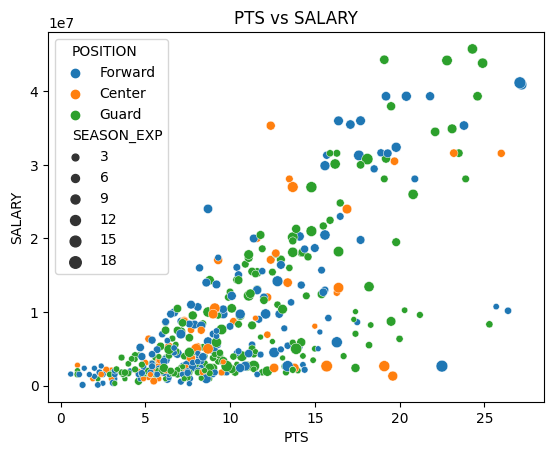

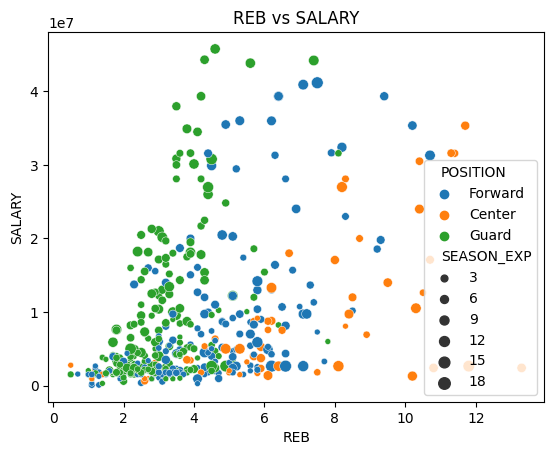

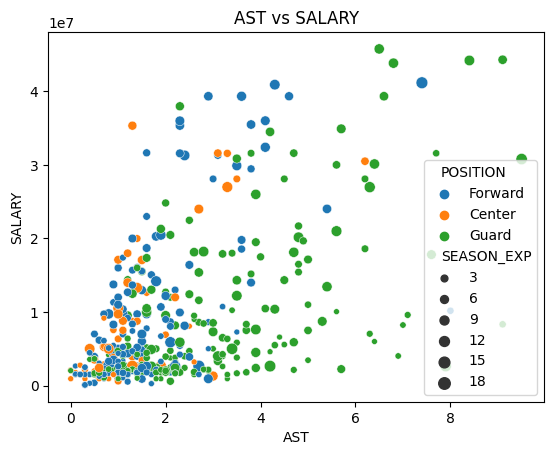

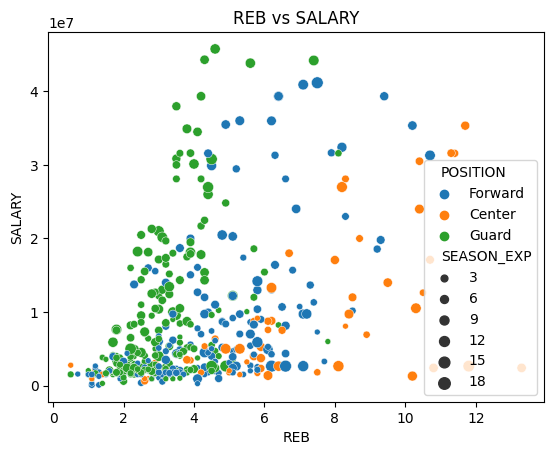

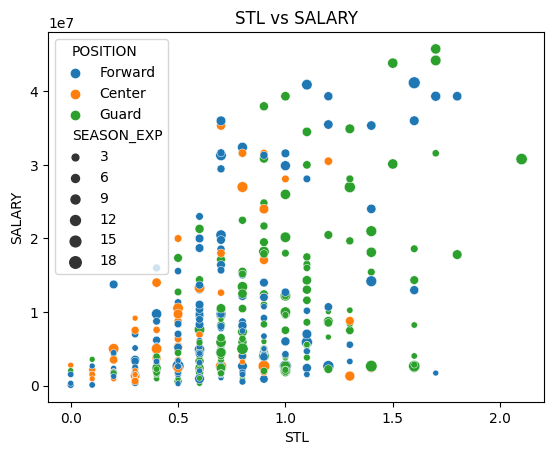

In [ ]:
features = ['PTS', 'REB','AST','REB', 'STL']
# graficamos cada una de las caracteristicas
for feature in features:
    sns.scatterplot(data=data, x=feature, y ='SALARY', size='SEASON_EXP', hue='POSITION').set_title(f'{feature} vs SALARY')
    plt.show()




1.2.  Que podemos decir de estas distribuciones?

### Dividimos nuestro Dataset

1.3. Divide el conjunto de datos en conjuntos de entrenamiento y prueba. Utiliza la función de Sklearn para la división de entrenamiento/prueba. Asegúrate de establecer el estado aleatorio para la reproducibilidad.

**Nota:** Antes de usar `train_test_split()` de scikit-learn, separa tu dataframe en características y etiquetas. Asigna tus características a la variable `X` y las etiquetas a `y`.

In [ ]:
# Pon aqui tus variable independientes
X = data.drop(columns=['SALARY'])
# Pon aqui tu variable dependiente
y = data['SALARY']

# Ahora usamos train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)


### No cambies nada en esta celda, solo tiene que correr correctamente*

### Modelo base y metrica de evaluacion

En cada proyecto, necesitamos un modelo base que implemente un algoritmo o heurística muy simple para que podamos comparar nuestros resultados con él.
En este caso, podríamos crear una función que siempre devuelva el salario promedio del jugador, evaluar eso y luego comparar el resultado con nuestra modelización para ver si estamos mejorando.


Necesitamos una métrica de evaluación para ver qué tan bien nuestros modelos se ajustan a los datos. Para este proyecto utilizaremos el [Error Absoluto Medio](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) como nuestra métrica de evaluación de regresión, porque es una métrica realmente sencilla de interpretar. Un valor más bajo significa que el modelo funciona mejor.

Para este problema en particular, siempre redondearemos el valor, ya que no necesitamos decimales para esta tarea.


1.4. Crea un modelo Base que implemente los metodos fit() y predict(). Como este modelo no va a considerar ninguna otra varible, el metodo fit tendria que reicibir una lista de todos los salarios de jugadores. El metodo predict tendria que recibir un iterable y retornar un array de numpy con el mismo largo, pero cada elemento tendria que tener el mismo valor (el salario promedio).

In [ ]:
class BaselineModel():
  """
  Un modelo base que siempre retorna siempre el mismo valor,
  la media de los salarios de los jugadores en los datos de entrenamiento
  """
  def fit(self, y_train):
    self.y_train = y_train
    self.mean = round(sum(y_train)/len(y_train))
    """
    Entrena con los datos de entrenamiento

    Parametros
    ----------
    y_train: Union[pd.Series, np.ndarray]
        una serie de pandas o array de numpy conteniendo la informacion del salario
    """


  def predict(self, X):
    length = len(X)
    self.fitted_values = np.array([self.mean] * length)
    return self.fitted_values
    """
    Salarios predichos

    Parameteros
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
        una serie de pandas, un dataframe o un array de numpy

    Returns
    -------
    np.ndarray
        un array de numpy del mismo largo que X, con todos los elementos iguales
        a la media calculada en fit()
    """


1.5. Evalua la performance de nuestro BaselineModel (nuestro modelo base) usando mean_absolut_error de Sklearn (redondea el resultado)

In [ ]:
# Instanciamos el modelo
baseline = BaselineModel()
# Entrenamos el modelo
baseline.fit(y_train)
# Obtenemos el error medio absoluto
mae_baseline = mean_absolute_error(y, baseline.predict(X['PTS']))
print(f'El mae para el modelo base es {round(mae_baseline, 2)}')

### Regresion con una sola variable

Ahora vas a comenzar a modelar datos. Comenzaremos con un enfoque realmente simple, seleccionando solo una variable y haciendo una regresión para ver si mejoramos con respecto a nuestra línea de base.


1.6. Selecciona la variable que creas que proporcionará el mejor ajuste. Realiza el escalado de características en esta variable utilizando un escalador de Sklearn.

In [ ]:
# Instanciamos el escalador

Scaler = RobustScaler()
# Fit the scaler and transform the data

pts_scaled_X_train = Scaler.fit_transform(X_train['PTS'].values.reshape(-1,1))
pts_scaled_X_test = Scaler.transform(X_test['PTS'].values.reshape(-1,1))



1.7.Entrena un modelo con [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) de Sklearn usando los parametros por default. Evalua la performance del modelo sobre el set de testeo usando las metricas seleccionadas.

In [ ]:
# Instancien el modelo con un random state (estado aleatorio)

# Entrenen el modelo con los datos

# Obtengan una prediccion

# Obtengan el error absolut medio para el modelo
mae_pts =

#  Hagan un print de los resultados obtenidos

if mae_baseline > mae_pts:
    print(f'El error de nuestro modelo base es mayor por {round((mae_baseline - mae_pts), 2)}')
else:
    print(f'El error de nuestra regresion simple es mayor por {round((mae_pts - mae_baseline),2)}')

1.8. Lee la documentación de Sklearn y escribe una función que pruebe diferentes configuraciones para los hiperparámetros para el entrenamiento: épocas, tasa de aprendizaje y alfa. Para cada combinación de parámetros, evalúa el algoritmo entrenado en el conjunto de prueba, luego guarda los resultados de cada combinación de hiperparámetros, finalmente selecciona el que tenga el mejor MAE (es decir, el número más bajo) e imprime la combinación y el MAE.

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
import math

def search_best_hyperparameters(max_iter, eta0):
  result = {
    "hyperparameters": {"max_iter": None, "eta0": None},
    "mae": None
  }
  # Completen aqui su codigo
  return result

In [ ]:
# Ejemplo de lista de valores de hiperparametros
max_iter = [10_000, 1_000_000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(max_iter, eta0)
print(result)

1.9. Compara los resultados del modelo base, el SGDRegressor con parámetros por defecto y el que tiene la mejor combinación de hiperparámetros que pudiste encontrar. (reemplaza las variables con las que usaste)


In [ ]:
print("MAE para cada modelo:")
print(f"Modelo base: {round(mae_baseline,2)}")
print(f"SGDRegressor con hiperparametros por default: {round(mae_pts, 2)}")
print(f"SGDRegressor con los mejores hiperparametros: {round(result['mae'],2)}")


### Regresión linear multivariada

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index) and name it mv_regression_df:

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]

In [ ]:
# Obtén las columnas solicitadas
mv_regression_df = data[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]]

# Establece person_ID como el índice.
mv_regression_df.set_index(data['PERSON_ID'])

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,SALARY
PERSON_ID,,,,,,,,
1630173,7.2,5.1,0.8,0.5,2,Forward,20,2711280
203500,9.3,8.0,1.5,0.9,9,Center,12,17073171
1628389,13.5,8.3,3.5,0.9,5,Center,14,28103550
1630583,4.1,2.7,0.7,0.3,1,Forward,30,1994520
200746,19.1,8.1,1.9,1.1,16,Center,2,2641691
...,...,...,...,...,...,...,...,...
1626153,7.2,3.2,3.0,0.4,7,Guard,20,8526316
201152,12.8,5.8,1.8,0.4,15,Forward,12,14190000
1629027,25.3,3.9,9.1,0.2,4,Guard,5,8326471


#### Feature Engineering

1.11. Creando bins para la característica DRAFT_NUMBER. La posición del draft impacta directamente en los salarios durante los primeros años, pero los jugadores de segunda ronda y los jugadores no seleccionados no tienen contratos garantizados. Por lo tanto, vamos a dividir los bins de esta manera:

       - 1 a 15: firstround_lottery
       - 15 a 30: firstround_non_lottery
       - 30 a 60: second_round
       - No seleccionados: undrafted

Crea una nueva columna llamada DRAFT usando estas 4 categorías. Elimina la columna draft number.


In [ ]:
# Las primeras dos líneas establecen los jugadores 'no reclutados' o las filas que tienen valores nulos como 0.
undrafted_mask = (mv_regression_df['DRAFT_NUMBER'] == 'Undrafted') | (mv_regression_df['DRAFT_NUMBER'].isna())
mv_regression_df.loc[undrafted_mask, 'DRAFT_NUMBER'] = 0

# Ahora, obtenemos el valor numérico de DRAFT_NUMBER.
mv_regression_df.loc[:,'DRAFT_NUMBER'] = pd.to_numeric(mv_regression_df['DRAFT_NUMBER'])

# Establece los límites de los contenedores como se solicita, con las etiquetas correspondientes.
bins = [-1, 0, 15, 30, 60]
labels = ['undrafted', 'firstround_lottery', 'firstround_non_lottery', 'second_round']

# Utilizamos la función cut de pandas para agrupar los datos en contenedores (bins).
mv_regression_df['DRAFT'] = pd.cut(x=mv_regression_df['DRAFT_NUMBER'], bins=bins, labels=labels)

# Ahora eliminamos la columna original, 'DRAFT_NUMBER'.
mv_regression_df.drop(columns=['DRAFT_NUMBER'], inplace=True)


<ipython-input-15-e8b6125fec8c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv_regression_df.loc[:,'DRAFT_NUMBER'] = pd.to_numeric(mv_regression_df['DRAFT_NUMBER'])
<ipython-input-15-e8b6125fec8c>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  mv_regression_df.loc[:,'DRAFT_NUMBER'] = pd.to_numeric(mv_regression_df['DRAFT_NUMBER'])
<ipython-input-15-e8b6125fec8c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

1.12. Codifica con dummies las siguientes características: DRAFT, POSITION

In [ ]:
# We use the pandas function get_dummies to get dummy variables from the categorical columns.
mv_regression_df = pd.get_dummies(data= mv_regression_df, columns=['DRAFT', 'POSITION'],drop_first=True)


#### Modelado

1.13. Divide el conjunto de datos en entrenamiento y prueba.

**Nota 1:** Antes de usar `train_test_split()` de scikit-learn, separa tu dataframe en características y etiquetas. Asigna tus características a la variable `X` y las etiquetas a `y`.

**Nota 2:** Recuerda eliminar la columna `DRAFT_NUMBER`.


In [ ]:
### Esto lo pueden hacer solos, porque tienen el ejemplo de arriba

# TODO: Pongan aqui sus caracteristicas (variables independientes)
X = None
# TODO: Pongan aqui sus etiquetas (labels)
y = None

# TODO: Ahora pueden usar train_test_split()





### *No cambies nada en esta celda, solo hazla correr correctamente*

1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number (which we will tackle next).

In [ ]:
### esto tambien lo pueden hacer solos, porque tienen el ejemplo de arriba.

# Instancien el escalador

# Fiteen y transformen los datos

# Pongan los datos en un dataframe para osbservalor mejor



1.15. Write a function to train an SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
import math
import numpy as np

# Definimos una lista de parametros que testearemos con numpy logspace
max_iter = np.logspace(3,6, num=3)
eta0 = np.logspace(-7,-2, num=5)

def search_best_hyperparameters_2(max_iter, eta0, X_train, X_test, y_train, y_test):

  result = {
    "hyperparameters": {"max_iter": None, "eta0": None},
    "mae": None
  }
  # tendran que reemplazar best_prediction con la mejor prediccion que vayan consiguiendo.
  # Cada vez que encuentren una prediccion mejor, reemplacen a la anterior ...
  best_prediction = math.inf


  return result

best_result = search_best_hyperparameters_2(max_iter, eta0, X_train, X_test, y_train, y_test)
best_result


1.16. How did the model perform compared to our univariate models?

### Analizando nuestros resultados


1.20. Hay algo mas que podriamos hacer para hacer al modelo mas acertado?

##2. Estrella o no? Prediciendo a los jugadores del All-nba


En esta sección vamos a intentar resolver una pregunta diferente:

¿Podemos entrenar un modelo para predecir qué jugadores serán seleccionados para los equipos ALL-NBA al final de la temporada? Esta es una tarea de [clasificación binaria](https://es.wikipedia.org/wiki/Clasificación_binaria), así que vamos a entrenar nuestro primer modelo de clasificación para resolver este problema.

Considera que:

- Ser seleccionado como parte de los [equipos All-NBA](https://es.wikipedia.org/wiki/All-NBA_Team) es diferente a ser seleccionado para el [Juego de las Estrellas](https://es.wikipedia.org/wiki/NBA_All-Star_Game).
- Estás intentando predecir las selecciones All-NBA, que tienen lugar después de la temporada regular pero antes de que comiencen los playoffs, así que solo vamos a utilizar estadísticas de jugadores y equipos sobre la temporada regular (no vas a considerar si los jugadores llegaron a las finales de la NBA por ejemplo).
- El Juego de las Estrellas se lleva a cabo en el punto medio de la temporada regular, los jugadores son seleccionados en base a un rendimiento parcial de la temporada, y el público en general tiene el 50% de los votos, por lo que también es un premio más basado en la popularidad.
- Los equipos All-NBA se dividen en primer, segundo y tercer equipos de 5 jugadores cada uno, divididos por posición: 2 jugadores de la línea frontal (guardias), 2 jugadores de la línea trasera (delanteros) y 1 centro.
- Como sólo 15 jugadores son seleccionados para los equipos All-NBA cada año (de más de 400 jugadores que califican), nuestro conjunto de datos va a estar desequilibrado. Vas a tener que encontrar una buena estrategia para lidiar con este desequilibrio.


###Analyzing los datos


Para realizar esta tarea, necesitarás información histórica sobre las selecciones de All-NBA. Utilizaremos un conjunto de datos que contiene información sobre jugadores desde la temporada que comenzó en 1990 hasta la temporada 2018-2019.
El conjunto de datos contiene estadísticas para todos los jugadores, y una columna denominada "all-nba" que será nuestra variable objetivo, 1 significa que el jugador fue seleccionado para un equipo All-NBA esa temporada.


2.1. Carga el conjunto de datos "all_nba_1990_2017_dataset.csv" desde el disco, observa los datos dentro de él e imprime:

- número de filas
- número de temporadas
- número de jugadores únicos
- número de selecciones all-nba vs no seleccionados

In [ ]:
# Load data
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

# Print rows
print(f'rows:{all_nba_df.shape[0]}')

# Get number of seasons
n_seasons = len(all_nba_df['season'].unique())

# Get total number of unique players
n_players = len(all_nba_df['player_id'].unique())

# Get total number of nba selection
all_nba_sel = sum(all_nba_df['all_nba'])

# Get number of "non-selections" to nba
all_nba_non_sel = all_nba_df['all_nba'].size - all_nba_sel

# Print data
print(f'numero de temporadas: {n_seasons}')
print(f'numero de jugadores: {n_players}')
print(f'Han habido {all_nba_sel:,} selecciones de all-nba, y {all_nba_non_sel:,} no-selecciones')

2.2. Divide el conjunto de datos en conjuntos de entrenamiento y prueba. Asegúrate de mantener la distribución de valores en la variable objetivo.

Utiliza las columnas: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
'2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'all_nba'.

***Nota***: Asigna tus características a la variable X y las etiquetas a y.



### Dividiendo el dataset en train y test

In [ ]:
from sklearn.model_selection import train_test_split

# TODO: Pongan aqui las variables independientes

# TODO: Pongan aqui la variable respuesta
y = all_nba_df['all_nba']

# TODO: Ahora usen train_test_split()
X_train, X_test, y_train, y_test_0 =


### *No cambies nada en esta celda, solo tiene que correr correctamente*

In [ ]:
mensaje = "Tus características/etiquetas tienen una forma incorrecta,\
por favor revisa tu código"
if X.shape == (14825, 15) and y.shape == (14825,):
  print('Exito!')
else:
  raise ValueError(mensaje)


### Modelo base y metricas de evaluacion

En esta oportunidad, definiremos nuestro modelo base como el modelo que podemos entrenar con la mínima cantidad de trabajo en el conjunto de datos. Para esto, vas a entrenar una [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) con parámetros por defecto, y sin hacer ningún preprocesamiento a nuestros datos.

```python
from sklearn.linear_model import LogisticRegression

# Crear el modelo de regresión logística
modelo = LogisticRegression()

# Entrenar el modelo con los datos
modelo.fit(X, y)


2.3. Empecemos con un test simple.Que accuracy podriamos obtener si tuvieramos un modelo base que siempre predice 0? (jugador no seleccionado para la NBA)?

In [ ]:
# Numero de verdaderos positivos va a ser 0, ya que no estoy prediciendo verdaderos positivos.
true_positive = 0

# Numero de verdaderos negativos sera el numero de negativos en el dataset
true_negative = y.shape[0] - y.sum()

# El total es el tamano del dataset
total = y.shape[0]

# calculamos el accuracy, usando la formula
accuracy = round(true_positive + true_negative/total, 3)
print(f'Mi modelo base tiene un accuracy de {accuracy}')

2.4. Que nos dice esto sobre el accuracy como metrica de evaluacion?

2.5. Escalamos todos las caracteristicas numericas del dataset(vamos a mantener este escalamiento para despues)

In [ ]:
# Instanciamos el escalador
scaler = RobustScaler()

# we hold the team in a different variable, so we can drop it drom df and the recover it
team_train = X_train['team']
team_test = X_test['team']

# we drop the only non-numerical feature
X_train_num = X_train.drop(columns=['team'])
X_test_num = X_test.drop(columns =['team'])

# we transform the data
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# We get the dataframes again
X_train = pd.DataFrame(X_train_scaled, columns=X_train_num.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_num.columns)

# we add again the team column which we had dropped
X_train['team'] = team_train
X_test['team'] = team_test


2.6. Entrena una [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) con parámetros por defecto, utiliza solo las características numéricas (omite la información del equipo por ahora). Este será nuestro modelo base.

```python
from sklearn.linear_model import LogisticRegression

# Crear el modelo de regresión logística
modelo = LogisticRegression()

# Asegúrate de usar solo las características numéricas, omite 'team' si está en tu conjunto


In [ ]:
# sacamos (dropeamos) la unica columna no numerica (teams)


# instanciamos un model de Regresion Logistica con sklearn


# entrenamos un modelo con el trai_test_split



2.7. Evalúa nuestro modelo base utilizando estas métricas:

    - exactitud (accuracy)
    - precisión (precision)
    - exhaustividad (recall)
    - puntuación f1 (f1)

In [ ]:
# Obtenemos la prediccion de nuestro set de testeo

# obtenemos el accuracy, precision, recall y f_score

# organizamos la informacion e imprimimos los resultados


From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall.

### Clasificacion

#### Feature engineering

2.8. Hacemos one hot encoding

In [ ]:
# aplicamos get dummies a nuestros sets de entrenamiento y de testeo
X_train = pd.get_dummies(data=X_train, columns=['team'])
X_test = pd.get_dummies(data=X_test, columns=['team'])

# Nos aseguramos que ambos tengan todos las columnas de teams (equipos)
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

# tenemos que sacar uno de los valores ...
X_train.drop(columns=['team_ATL'], inplace=True)
X_test.drop(columns=['team_ATL'], inplace=True)


#### Modelado

2.9. Entrena un modelo de regresión logística, encuentra los mejores hiperparámetros para: tols, C y max_iter. Intenta al menos 4 valores para cada hiperparámetro. Recuerda seleccionar basado en el f1 score, pero tambien reporta la precisión y el recall. Guarda el modelo que mejores resultados dio para usar en los próximos pasos.

In [ ]:
import math
import sklearn
import warnings
warnings.filterwarnings("ignore", module='sklearn.linear_model')

#  definan una lista de hiperparametros. Aqui les dejamos un ejemplo, pero pueden usar otros
tol_params = [0.00001, 0.0001, 0.001, 0.01]
C_params = [0.001, 0.01,1, 100]
max_iter_params = [ 1_000,10_000, 100_000, 1_000_000]
best_f_score = 0

warnings.resetwarnings()

In [ ]:
print(result)
my_logistic_model = result['model']


#### Evaluando sobre datos nuevos

Ahora vas a evaluar los resultados en un conjunto de datos de prueba que no ha sido utilizado para entrenar o hacer ajuste de hiperparámetros, esto a veces se conoce como un conjunto de Test (en estos casos, el conjunto de test utilizado para entrenamiento se conoce como conjunto de validación, sí, es confuso, pero puedes leer sobre ello [aquí](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Carga el conjunto de datos [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) en un dataframe y [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) en otro, luego:

    - Escala las características numéricas. Las columnas season_id, player_id, player_season, player, season y season_start no se utilizarán para la predicción, puedes conservarlas pero recuerda no pasarlas al clasificador.

    - Crea las características codificadas en caliente para el equipo. Este paso será complejo, ya que tendrás que considerar que en la temporada 2018 hay 30 equipos, pero el conjunto de datos anterior contiene 40 equipos, eso se debe a que muchos equipos cambiaron de nombre o de ciudad a lo largo de los años. Necesitas agregar esos 10 nombres de equipos diferentes en este conjunto de datos (con todos los valores en 0) para hacer que el clasificador funcione.


In [ ]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [ ]:
all_nba_2018_df.head()

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
34,34,5,2,Alex Abrines,2018-19,2018,OKC,31,2,19.0,...,0.323,0.500,0.923,1.5,0.6,0.5,0.2,0.5,1.7,5.3
49,49,8,7,Quincy Acy,2018-19,2018,PHO,10,0,12.3,...,0.133,0.667,0.700,2.5,0.8,0.1,0.4,0.4,2.4,1.7
70,52,10,1,Jaylen Adams,2018-19,2018,ATL,34,1,12.6,...,0.338,0.361,0.778,1.8,1.9,0.4,0.1,0.8,1.3,3.2
71,71,13,6,Steven Adams,2018-19,2018,OKC,80,80,33.4,...,0.000,0.596,0.500,9.5,1.6,1.5,1.0,1.7,2.6,13.9
79,79,15,2,Bam Adebayo,2018-19,2018,MIA,82,28,23.3,...,0.200,0.588,0.735,7.3,2.2,0.9,0.8,1.5,2.5,8.9


In [ ]:

# Get the correct columns
all_nba_2018_df = all_nba_2018_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]


In [ ]:
# Guardamos la columna team para poder sacarle luego de nuestro dataset y no perderla

team_all_nba = all_nba_2018_df['team']

# sacamos la columna team (equipos)
all_nba_2018_df.drop(columns=['team'], inplace=True)

# escalamos los datos
all_nba_2018_df = pd.DataFrame(scaler.transform(all_nba_2018_df), columns=all_nba_2018_df.columns)

# reinsertamos la columna teams en nuestro set de testeo
all_nba_2018_df['team'] = team_all_nba


In [ ]:
X = all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
X = pd.get_dummies(data= X, columns=['team'])
# aplicamos get dummies para 2018 df
all_nba_2018_df = pd.get_dummies(data=all_nba_2018_df, columns=['team'])

# reindexamos con las columnas del dataframe original. Las columnas que no se encuentren\
# en 2018_df seran llenadas con valores 0.
all_nba_2018_df = all_nba_2018_df.reindex(columns= X.columns, fill_value=0)

# nos deshacemos del mismo equipo que en el set de entrenamiento
all_nba_2018_df.drop(columns=['team_ATL'], inplace=True)



### *No cambies nada aqui. Solo tiene que correr correctamente*

In [ ]:
if all_nba_2018_df.shape == (530, 54):
  print('Success!')
else:
  raise ValueError('La forma es incorrecta. Por favor resiva tu funcion')

2.11. Predice y evalue el modelo usando precision, recall y f1 score.

In [ ]:
# definimos la variable y_test, que es la columna "all_nba" en all_nba_2018_selections df

# Obtenemos la prediccion

# Obtenemos metricas


# Imprimimos las metricas



2.12. Analiza los resultados, ¿qué crees que está sucediendo?

#### Creando un clasificador a medida


Una cosa a tener en cuenta en este problema, es que el número de selecciones All NBA es fijo cada año, siempre se seleccionan un total de 15 jugadores. Pero nuestro modelo actual no limita el número de jugadores clasificados positivamente. Por lo tanto, tendremos que envolver nuestro modelo en un clasificador personalizado que sólo devuelva como positivos a los 15 jugadores con las mayores probabilidades.
Afortunadamente, nuestro modelo elegido proporciona acceso a las probabilidades subyacentes.

2.13. Usando el modelo entrenado, predice las probabilidades para todas las filas del dataset, y crea una nueva columna que tiene la probabilidad que el jugador haya sido seleccionado como all-nba. Redondea la probabilidad a 3 decimales.

In [ ]:
# Obtenemos las probabilidades con el metodo predict_proba


2.14. Ordena el conjunto de datos por probabilidades y muestra los 15 jugadores con mayor probabilidad de haber sido seleccionados

In [ ]:
# Ordenamos por probabilidades y seleccionamos los 15 jugadores con mas chances de ser
# seleccionados al all_nba
# van a tener que buscar un poco en la documentacion de pandas para hacer esto



print('Los quince jugadores con mas chance de entrar en la seleccion del all_nba son: ')
# imprimimos aqui nuestra lista de 15 jugadores ...

2.15. Imprime:

    - Jugadores realmente seleccionados del conjunto de datos all_nba_2018_selections,
    - Jugadores realmente seleccionados que faltan en NUESTRAS predicciones+
    - Jugadores en nuestras predicciones no seleccionados


In [ ]:
# Obtenemos los jugadores seleccionados en 2018

# Jugadores seleccionados que no estan en nuestras predicciones

# Jugadores que predijimos pero no estaban incluidos en la seleccion del all_nba


# Imrpimimos los resultados
print('Los jugadores seleccionados al all_nba son:')
# Imprimimos aqui la variable que corresponde ...



In [ ]:
print('Jugadores seleccionados que NO estan en nuestra prediccion: ')
# imprimimos la variable correspondiente

In [ ]:
print('Jugadores que SI estan en nuestra prediccion, pero que no fueron seleccionados: ')
# Imprimimos la variable correspondiente ...

In [ ]:
### Opcional:

2.16. Crea una clase llamada AllNbaSingleSeasonClassifier que toma un modelo de scikit learn en el constructor y luego implementa un método predict que retorn predicciones con solo las 15 selecciones más probables.

In [ ]:
import random as rd
class AllNbaSingleSeasonClassifier():
  def __init__(self, model):
    """
    Class constructor

    Parametros
    ----------
    model: BaseEstimator
      un estimador de Scikit learn
    """
    self._model = model

  def predict(self, X):
    """
    Predice las selecciones del all-nba. Este clasificador va a limitar el numbero
    de instancias positivas a 15

    Parametros
    ----------
    X: pd.DataFrame
      un dataframe con la data de los jugadores


    Returns
    -------
    np.ndarray
      Un array de la misma longitud que y, con 15 resultados positivos basados en los
      jugadores con mayor probabilidad de ser seleccionados
    """


2.17. Usa el nuevo clasificador para hacer predicciones y evaluar los resultados con accuracy, recall y f1.

In [ ]:
# Predecimos los 15 jugadores que iran al all_nba

# Calculamos las metricas

# imprimimos resultados


#### Analizando nuestros resultados

2.18. ¿Cuál piensas que es el principal problema con este dataset y la forma en que entrenamos nuestro modelo?

2.19. ¿Qué piensas que podríamos hacer para mejorar nuestro modelo?